In [1]:
from shapely.geometry import Polygon, Point
import pointpats
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.strtree import STRtree
import numpy as np
from SimuSamp.new_funcs.load.SpatDat import SpatDat
import pandas as pd
from SimuSamp.new_funcs.compute.n_core_sampler import sample_n_cores

In [2]:
parent_filepath = "../../../../../Simulated WS Sampling/block_data"
sampleids = ["01_F", "01_G", "02_G", "02_H", "03_B", "03_H", "04_I", "04_N", "05_G", "05_I", "06_H", "07_K", "08_J", "09_E", "10_B", "11_E", "11_F", "12_M", "13_G", "14_I", "15_G", "16_B", "17_I", "18_E", "19_F", "21_I", "22_N", "23_B", "24_I", "25_M", "26_I", "27_H", "28_FSC", "29_L", "30_D"]

microns_per_pixel=0.22715
mm2_per_pixels2 = (microns_per_pixel / 1000) ** 2

r = 0.5 * 1000 / microns_per_pixel
n = 10

In [11]:
samples = []
den = []
area = []
for sample in sampleids:
    spatdat = SpatDat(sampleid=sample, parent_filepath=parent_filepath)

    tum_cells = spatdat.subset_cells("tumour")
    tum_area = spatdat.subset_annotation("tumour").area * mm2_per_pixels2
    tum_density = len(tum_cells) / tum_area

    den.append(tum_density)
    samples.append(sample)
    area.append(tum_area)

den_df = pd.DataFrame({"sample": samples, "density": den, "area": area})

In [12]:
den_df

,sample,density,area
0,01_F,804.022884,198.490619
1,01_G,225.027071,29.463122
2,02_G,1049.946522,35.433233
3,02_H,431.779689,71.344254
4,03_B,33.618035,47.355534
5,03_H,91.502656,20.196135
6,04_I,346.394474,143.013251
7,04_N,363.616220,127.398057
8,05_G,379.291157,43.771123
9,05_I,423.454086,30.461390


In [13]:
den_df.iloc[den_df["area"].idxmax()]

sample           08_J
density    325.787646
area       221.622891
Name: 12, dtype: object

In [14]:
den_df.iloc[den_df["density"].idxmax()]

sample            02_G
density    1049.946522
area         35.433233
Name: 2, dtype: object

In [15]:
spatdat = SpatDat(sampleid="08_J", parent_filepath=parent_filepath)

In [16]:
cells = spatdat.subset_cells("extended_partition")
tum_cells = spatdat.subset_cells("tumour")
im_cells = spatdat.subset_cells("IM")
tum = spatdat.subset_annotation("tumour")
ext_partition = spatdat.subset_annotation("extended_partition")
im = spatdat.subset_annotation("IM")
outer_im = spatdat.subset_annotation("outer_IM")

In [17]:
im_polygon = gpd.GeoDataFrame(geometry=[im])

In [18]:
pgon = tum
polygon = gpd.GeoDataFrame(geometry=[pgon])

In [9]:
def int_area(point, poly, r=0.2):

    intersection_area = point.buffer(r).intersection(poly).area
    core_area = np.pi * r**2

    fraction = intersection_area / core_area

    return fraction

In [10]:
# Generates random points inside polygon
random_points = spatdat.poisson_distribution("tumour")

print(f"{len(random_points)} points calculated.")

KeyboardInterrupt: 

In [ ]:
# Shuffle gdf for randomization
random_points = random_points.sample(frac=1).reset_index(drop=True)

point_list = []
tree = STRtree(point_list)
for idx, point in random_points.iterrows():
    if not any(tree.query(point.geometry, predicate="dwithin", distance=2*r)):
        
        # Evaluate core eligibility
        fraction = int_area(point.geometry, pgon, r)
        
        if fraction >= 0.5:
            point_list.append(point.geometry)
            tree = STRtree(point_list)

In [ ]:
filtered_gdf = gpd.GeoDataFrame(geometry=point_list)
filtered_gdf = filtered_gdf.drop(0, axis=0) # Drop initial point
filtered_gdf_buffer = filtered_gdf.buffer(r)

n_samples = min([n, int(len(filtered_gdf_buffer))])

sampled_gdf = filtered_gdf_buffer.sample(n_samples)

n_sampled = len(sampled_gdf)

n_cores_sampled:  10


<Axes: >

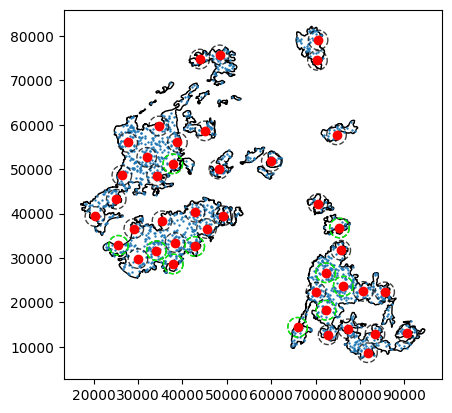

In [ ]:
print("n_cores_sampled: ", n_sampled)
polygon.plot(color="None")
random_points.plot(ax=plt.gca(), markersize=0.5)
filtered_gdf.plot(ax=plt.gca(), color="red")
filtered_gdf_buffer.plot(ax=plt.gca(), color="None", edgecolor="black", alpha=0.75, linestyle="--")
sampled_gdf.plot(ax=plt.gca(), color="None", edgecolor="lime", linestyle="--")

In [34]:
cores = sampled_gdf.reset_index(drop=True)

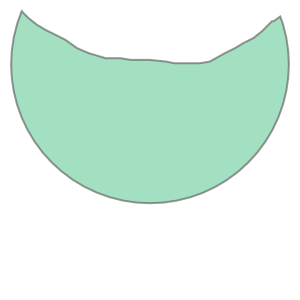

In [17]:
core = cores.geometry[5].intersection(ext_partition)
core

In [18]:
core_gdf = gpd.GeoDataFrame(geometry=[core])
core_cells = gpd.sjoin(cells, core_gdf, predicate="within")

In [35]:
cores = gpd.GeoDataFrame(geometry=cores)

In [37]:
core_rand_points = gpd.sjoin(random_points, cores, predicate="within")

<Axes: >

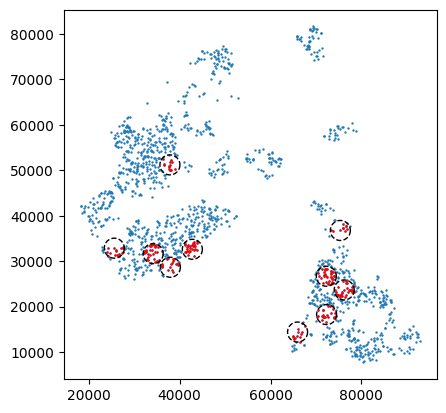

In [40]:
random_points.plot(markersize=0.5)
core_rand_points.plot(color="red", ax=plt.gca(), markersize=0.5)
cores.plot(ax=plt.gca(), color="None", edgecolor="black", linestyle="--")

In [22]:
random_points = pointpats.random.poisson(core, size=len(core_cells))
random_points = [Point(p) for p in random_points]
random_gdf = gpd.GeoDataFrame(geometry=random_points)

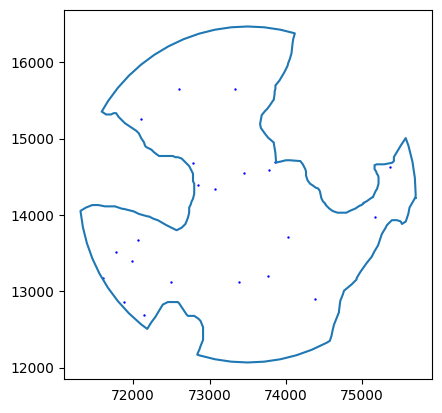

In [23]:
random_gdf.plot(color="blue", markersize=0.5)
plt.plot(*core.exterior.xy)

In [24]:
res = sample_n_cores(spatdat, region="tumour", core_radius=0.5, n_core_list=[5], iterations=5)

In [25]:
eligible_points = gpd.GeoDataFrame(res, geometry="eligible_points")
sampled_cores = gpd.GeoDataFrame(res, geometry="cores")

<Axes: >

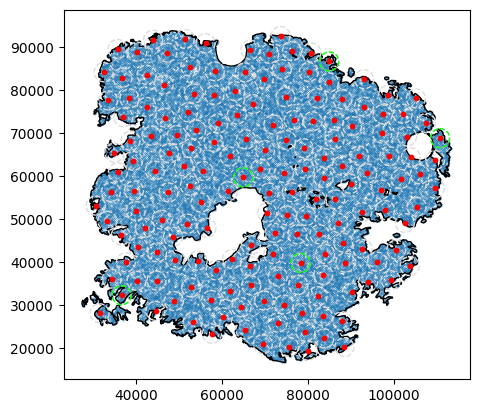

In [34]:
idx = 0
radius = eligible_points.iloc[[idx]]["core_radius"][0]
region = eligible_points.iloc[[idx]]["region"][0]
spatdat.poisson_cells[region].plot(markersize=0.05)
polygon.plot(ax=plt.gca(), color="None")
if region == "IM":
    im_polygon.plot(ax=plt.gca(), color="None", edgecolor="black", linestyle="--")
eligible_points.iloc[[idx]].plot(ax=plt.gca(), color="red", markersize=10)
eligible_points.iloc[[idx]].buffer(radius * 1000 / microns_per_pixel).plot(ax=plt.gca(), color="None", edgecolor="gainsboro", linestyle="--")
sampled_cores.iloc[[idx]].plot(ax=plt.gca(), color="None", edgecolor="lime", linestyle="--")

In [12]:
res.to_excel("sampled_cores.xlsx")